In [1]:
N = 12
J_value = 1
J_matrix_alpha = 1
import torch
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device( "cpu")

In [2]:
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import eigsh
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy
np.set_printoptions(precision=6)
# initialize variables

# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# decimal number to binary array function
def D2B_with_digit(num,digit):
    string = f'{num:1b}'
    result = np.zeros(digit - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result

# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    new_array = np.zeros(len(array),dtype=int)
    for i in range(len(array)):
        if array[i] == 1:
            new_array[i] = 0
        else:
            new_array[i] = 1
    return new_array

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array

# start my main function

# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')

for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

In [3]:
# start to get what product states are having the same symmtries
loop_state_list = np.linspace(0,Q-1,num=Q,dtype=int)

couple_state_matrix = []
sign_matrix = []
# this is the final result for the states to consctruct basis 

for n in range(Q):  # n is an unused index
    
    # couple_num_list would be my result for each state we loop
    
    if len(loop_state_list)!=0: # loop for couple number for one state
                
        couple_num_list = [] # this is the list to store all the number that couple to the number we are looping
        couple_num_list = np.array(couple_num_list, dtype=int)
        state_num = loop_state_list[0]
        couple_num_list = np.append(couple_num_list,state_num)
        
        for m in range(Q): # loop for spin and spatial for all states inside the couple number list
            
            if m==0:
                
                couple_num_list_old =couple_num_list
                
                for i in range(len(couple_num_list)):
                    number = couple_num_list[i]
                    array = D2B(number)

                    # spin reflection 
                    spin_relfection_array = spin_reflection(array)
                    spin_number = B2D(spin_relfection_array)
                    couple_num_list =np.append(couple_num_list,spin_number)



                    # # spatial reflection 
                    spatial_relfection_array = spatial_reflection(array)
                    spatial_number = B2D(spatial_relfection_array)
                    couple_num_list =np.append(couple_num_list,spatial_number)
                    
                    # remove the repeated element 
                    couple_num_list = np.unique(couple_num_list)
            else:
                
                if len(couple_num_list_old) != len(couple_num_list):
                    # update couple_num_list_old first 
                    couple_num_list_old =couple_num_list
                    
                    for i in range(len(couple_num_list)):
                        number = couple_num_list[i]
                        array = D2B(number)

                        # spin reflection 
                        spin_relfection_array = spin_reflection(array)
                        spin_number = B2D(spin_relfection_array)
                        couple_num_list =np.append(couple_num_list,spin_number)
                        
                        
                        # # spatial reflection 
                        spatial_relfection_array = spatial_reflection(array)
                        spatial_number = B2D(spatial_relfection_array)
                        couple_num_list = np.append(couple_num_list,spatial_number)
                        
                        # remove the repeated element 
                        couple_num_list = np.unique(couple_num_list)
                        
        # now we have final couple_num_list
        couple_state_matrix.append(couple_num_list.tolist())
        
        # remove the ones already found 
        for j in range(len(couple_num_list)):
            loop_state_list = np.delete(loop_state_list, np.where(loop_state_list ==couple_num_list[j] ))

In [4]:
# initialize H matrix
couple_dimen = len(couple_state_matrix)

HA_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')
HB_matrix = np.zeros((couple_dimen, couple_dimen), dtype='float64')

# loop each basis to fill in the diagonal elements for HA matrix 

for i in range(couple_dimen):
    
    state_array = np.array( couple_state_matrix[i] )
    
    # loop each element inside the array 
    normalization = len(state_array)
    
    # energy total for all the product states inside one basis
    
    e_tot = 0
    for j in range(len(state_array)):
        
        state = D2B(state_array[j])
        
        # loop over N sites to change the state vector to either 1 or -1
        
        for k in range(N):
            # 1 is spin down , 0 is spin up
            if state[k] == 1:
                state[k] = -1
            else:
                state[k] = 1

        # now get the energy, loop all the sites and then pairs
        
        for m in range(N):
            for q in range(N):
                e_temp = J_matrix[m][q] * state[m] * state[q]
                e_tot = e_tot + e_temp

    HA_matrix[i][i] = e_tot/normalization

# generate vector form for each basis
vector_form_basis_matrix = np.zeros((couple_dimen,Q))

for i in range(couple_dimen):
    
    state_array = np.array( couple_state_matrix[i] )
    normalization = np.sqrt(len(state_array))
    
    for j in state_array:
        vector_form_basis_matrix[i][j] = 1
        
    # put back normalization factor
    vector_form_basis_matrix[i] = vector_form_basis_matrix[i]/normalization
    
# loop each basis to fill in HB matrix 

for i in range(couple_dimen):

    state_array = np.array( couple_state_matrix[i] )

    # this is the actual normalization unlike before since it will couple to some other states
    # so it can not be like just the square like we did before
    normalization = np.sqrt(len(state_array))

    # loop each product state to generate N other states, i.e. generaete the state after operator acting on it
    result_num_list = []
    result_num_list = np.array(result_num_list,dtype=int)
    for k in range(len(state_array)):
        
        spin = D2B(state_array[k])

        # start fliping the spins
        for j in range(N):
            if spin[j] == 1:
                # if it's spin down, raise to spin up
                spin[j] = 0
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 1
            else:
                # if it's spin down, raise to spin up
                spin[j] = 1
                new_num = B2D(spin)
                result_num_list = np.append(result_num_list,new_num)
                # change it back for next operation
                spin[j] = 0
        
     
    # generate the vector form for the state after operrator acting on it
    
    vector_final_state = np.zeros(Q)
    
    for j in result_num_list:
        vector_final_state[j] = vector_final_state[j] +1
        
    # put back normalization factor 
    vector_final_state = vector_final_state/normalization
    
    # calculate dot product to put into inside the matrix
    for j in range(couple_dimen):
        
        dot_product = np.dot(vector_final_state,vector_form_basis_matrix[j])
        HB_matrix[i][j] = dot_product    

In [5]:
B = 0.1  # !!! NEED TO BE CHANGED
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh(HA_matrix + B * HB_matrix, k=1, which='SA')

true_gs_energy = smallest_eigenvalue[0]
true_gs_vec = smallest_eigenvector[:, 0]

# Compute the largest eigenvalue
largest_eigenvalue = eigs(HA_matrix + B * HB_matrix, k=1, which='LR', return_eigenvectors=False)

E_max = largest_eigenvalue[0].real

In [6]:
true_gs_energy

-7.887943169537985

In [7]:
# get  ground state with numerically infinite large B field
# Compute the smallest eigenvalue and eigenvector
smallest_eigenvalue, smallest_eigenvector = eigsh( HB_matrix, k=1, which='SA')
temp_vec = smallest_eigenvector[:, 0]

In [8]:
# move to gpu
true_gs_vec = torch.tensor(true_gs_vec.astype(np.complex128)).to(device=device)
temp_vec = torch.tensor(temp_vec.astype(np.complex128)).to(device=device)

HA_matrix = torch.tensor(HA_matrix, dtype=torch.complex128).to(device=device)
HB_matrix = torch.tensor(HB_matrix, dtype=torch.complex128).to(device=device)
target_H = HA_matrix + B * HB_matrix

In [9]:
def get_fidelity_torch(vector1, vector2):
    overlap = torch.tensordot(vector1, vector2, dims=1)
    overlap_conj = torch.conj(overlap)
    fidelity = torch.real(overlap * overlap_conj)
    return fidelity

def get_energy_torch(matrix, vector):
    conj_vector = torch.conj(vector)
    energy = torch.real(torch.tensordot(conj_vector, torch.tensordot(matrix, vector, dims=1), dims=1))

    return energy

In [10]:
get_energy_torch(target_H,true_gs_vec).item()- true_gs_energy

-7.105427357601002e-15

In [11]:
# get fidelity for t= 0s
fidelity_t_0 = get_fidelity_torch(true_gs_vec,temp_vec)
print(fidelity_t_0)

tensor(0.0014, device='cuda:0', dtype=torch.float64)


In [12]:
def lambda_evolve(x):
    global fidelity
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    # fidelity = get_fidelity_torch(true_gs_vec, p)
    # print(fidelity)
    energy = get_energy_torch(target_H, p)
    
    return energy

In [13]:
def clean_array_by_threshold(arr, threshold=0.001):
    # Ensure the array is a numpy array
    arr = np.array(arr)
    
    # Determine the length of the array
    n = arr.shape[0]
    
    # Ensure the array has an even number of elements
    if n % 2 != 0:
        raise ValueError("The input array must have an even number of elements.")
    
    # Determine the half-length of the array
    half_n = n // 2
    
    # Find indices in the first half where absolute values of elements are smaller than the threshold
    indices_to_remove = np.where(np.abs(arr[:half_n]) < threshold)[0]
    
    # Create a mask to keep elements that are not to be removed
    mask = np.ones(n, dtype=bool)
    mask[indices_to_remove] = False
    mask[indices_to_remove + half_n] = False
    
    # Apply the mask to remove elements
    cleaned_arr = arr[mask]
    
    return cleaned_arr

In [14]:
#best result N=12,10 LAYERS, 64 bits
x_10 =np.array([0.4072185919308115, 1.2954691806813516, 0.5805573609066998, 0.8454189546075643, 1.2243197218332320, 2.1572222947038711, 2.5905765854250022, 2.7409062412055198, 2.0081536293189819, 0.9755810490605400, 4.9955913368774452, 1.7717120168593767, 1.0871728400196139, 0.7185240323450447, 0.5732536483420920, 0.4951459317676031, 0.4388398363271400, 0.3901464618527199, 0.3117549554184353, 0.1945036761838408])
x_10 = torch.tensor(x_10, dtype=torch.float64, device=device, requires_grad=False)

In [15]:
# best result N=12,19 LAYERS,64 bits
x_20 =np.array([ 0.327776,  0.474971,  0.273948,  1.144375,  0.39613 ,  0.469455,
        0.61746 ,  0.71229 ,  1.606741,  2.45683 ,  2.329665,  2.300839,
        2.067805,  0.767213,  1.982016,  1.088733,  1.654539,  1.20256 ,
        1.599378, 11.170304,  4.166785,  2.284776,  1.569997,  1.193193,
        0.900791,  0.749189,  0.627265,  0.558349,  0.48868 ,  0.448456,
        0.420571,  0.379537,  0.343144,  0.301675,  0.264275,  0.237982,
        0.170687,  0.123693])
x_20 = torch.tensor(x_20, dtype=torch.float64, device=device, requires_grad=False)

In [16]:
# best result N=12,28 LAYERS,64 bits
x_30 =np.array([ 0.372775,  0.179961,  0.390973,  1.425035,  0.510744,  1.729341,
        0.450043,  0.453797,  1.903975,  1.265933,  0.588657,  1.078548,
        0.579753,  1.712308,  0.678603,  1.718906,  2.534426,  1.285703,
        1.341049,  0.693764,  0.570384,  0.675155,  0.808742,  2.114068,
        0.826767,  0.870555,  1.020514,  1.043119, 13.586468,  3.363042,
        1.634305,  1.4103  ,  1.21528 ,  1.117821,  0.991998,  0.83695 ,
        0.743113,  0.717898,  0.658147,  0.626936,  0.603037,  0.547218,
        0.514397,  0.480427,  0.454724,  0.420769,  0.430994,  0.392782,
        0.36764 ,  0.342992,  0.306503,  0.275602,  0.250099,  0.211784,
        0.173192,  0.123975])
x_30 = torch.tensor(x_30, dtype=torch.float64, device=device, requires_grad=False)

In [17]:
# best result N=12,46 LAYERS,64 bits
x_50 =np.array([ 0.097725,  0.477288,  0.443276,  0.172682,  1.246086,  0.880701,
        0.311077,  0.343559,  0.4446  ,  0.498634,  3.513766,  2.195835,
       -1.679474,  2.34228 ,  1.033489,  3.00999 , -0.583254, -1.904584,
        6.23439 ,  0.627215,  0.72342 ,  0.945287,  0.84764 ,  2.777252,
        0.920419,  0.795509,  0.771761,  1.074029,  0.849288,  0.778886,
        2.109009,  2.799745,  2.618029,  9.436081, -6.322151,  9.304835,
        0.817901,  0.557422,  0.670992,  0.875811,  5.658462, -0.068928,
        0.289072,  5.464772,  2.425481,  1.070671, 23.078089,  7.676801,
        4.609007,  3.1356  ,  2.488154,  2.080197,  1.473614,  1.071259,
        0.827909,  0.710397,  0.655159,  0.635309,  0.610464,  0.589641,
        0.570621,  0.552939,  0.528794,  0.507812,  0.486003,  0.456375,
        0.418009,  0.388989,  0.374755,  0.359278,  0.349239,  0.336304,
        0.314521,  0.293763,  0.279373,  0.261307,  0.24796 ,  0.243052,
        0.236972,  0.232609,  0.236054,  0.227522,  0.218561,  0.199195,
        0.179152,  0.151823,  0.135518,  0.330649,  0.170398,  0.117737,
        0.115771,  0.107222])
x_50 = torch.tensor(x_50, dtype=torch.float64, device=device, requires_grad=False)

In [18]:
def lambda_evolve(x):
    number_of_layers = len(x)//2
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p

    fidelity = get_fidelity_torch(true_gs_vec, p)
    # print(fidelity)
    # energy = get_energy_torch(target_H, p)
    
    return fidelity

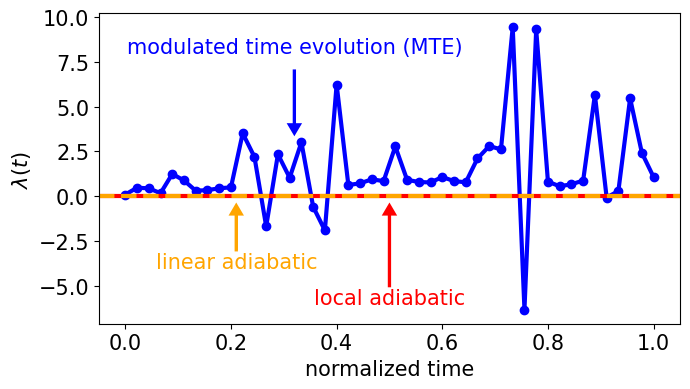

In [19]:
# lambda plot 
plt.figure(figsize=(7, 4))
plot_x = x_50[:46].detach().cpu().numpy()
plt.plot(np.linspace(0,1,len(plot_x)),plot_x,color='blue',linewidth=3)
plt.plot(np.linspace(0,1,len(plot_x)),plot_x,'o',color='blue')
plt.tick_params(axis='y', labelcolor='black', labelsize=15)
plt.tick_params(axis='x', labelcolor='black', labelsize=15)
plt.ylabel(r'$\lambda(t)$ ', color='black', size=15)
plt.xlabel(r'normalized time', size=15)

## draw lambda constant line
plt.axhline(y = 0.01, color = 'r', linestyle = '-', linewidth=3)
plt.axhline(y = 0.01, color = 'orange', linestyle = '--', linewidth=3)

# # insert text saying which color is which
plt.text(x=0.32, y=8, s='modulated time evolution (MTE)', color='blue', fontsize=15, ha='center')
plt.arrow(0.32,7, 0,-3, head_width=0.02, head_length=0.5, fc='blue', ec='blue', linewidth=2)


plt.text(x=0.21, y=-4, s='linear adiabatic', color='orange', fontsize=15, ha='center')
plt.arrow(0.21,-3, 0,2, head_width=0.02, head_length=0.5, fc='orange', ec='orange', linewidth=2)

# plt.text(x=0.915, y=-4, s=r'$\lambda(t) =0.01$ ', color='orange', fontsize=15, ha='center')



plt.text(x=0.5, y=-6, s='local adiabatic', color='red', fontsize=15, ha='center')
plt.arrow(0.5,-5, 0,4, head_width=0.02, head_length=0.5, fc='red', ec='red', linewidth=2)

# plt.text(x=0.915, y=-6, s=r'$\lambda(t) =0.01$ ', color='red', fontsize=15, ha='center')

plt.tight_layout()
plt.savefig('lambda_plot')

In [20]:
def get_energy_list(x):
    number_of_layers = len(x)//2
    energy_list = []
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p
        energy = get_energy_torch(target_H, p)
        energy_list.append(energy.item())

    return energy_list

In [21]:
def get_fidelity_list(x):
    number_of_layers = len(x)//2
    fidelity_list = []
    norm_list = []
    p = temp_vec.clone().to(torch.complex128)  # Create a copy of temp_vec

    for i in range(number_of_layers):
        H_matrix = HA_matrix + x[i+number_of_layers] * HB_matrix
        exp_imgH_matrix = torch.matrix_exp(-1j * x[i] * H_matrix)
        new_p = torch.matmul(exp_imgH_matrix, p)
        p = new_p
        fidelity = get_fidelity_torch(true_gs_vec, p)
        vector_norm = torch.norm(p)
        fidelity_list.append(fidelity.item()/vector_norm.item())
        norm_list.append(vector_norm.item())

    return fidelity_list,norm_list

In [22]:
# # Obtain the fidelity lists
# f_list_5 = np.array(get_fidelity_list(x_5))
# f_list_10 = np.array(get_fidelity_list(x_10))
# f_list_15 = np.array(get_fidelity_list(x_15))
# f_list_20 = np.array(get_fidelity_list(x_20))
# f_list_25 = np.array(get_fidelity_list(x_25))
# f_list_30 = np.array(get_fidelity_list(x_30))
# f_list_40 = np.array(get_fidelity_list(x_40))
# f_list_50 = np.array(get_fidelity_list(x_50))
# f_list_60 = np.array(get_fidelity_list(x_60))

In [23]:
# read B field file 
time_and_B_data = pandas.read_csv(f"B_profile_N={12}_a={1}_B_start={20}_B_0={0.1}.csv")
time_list = time_and_B_data['time'].to_numpy()
time_list = time_list/np.max(time_list)
B_list = time_and_B_data['B'].to_numpy()
number_of_layers = 1000

bi = Akima1DInterpolator(time_list, B_list)
t_data_smooth = np.linspace(min(time_list), max(time_list),number_of_layers)# Number of steps to take for time evolution 
B_data_smooth = bi(t_data_smooth)

In [24]:
linear_ramp = np.linspace(20,0.1,10000)

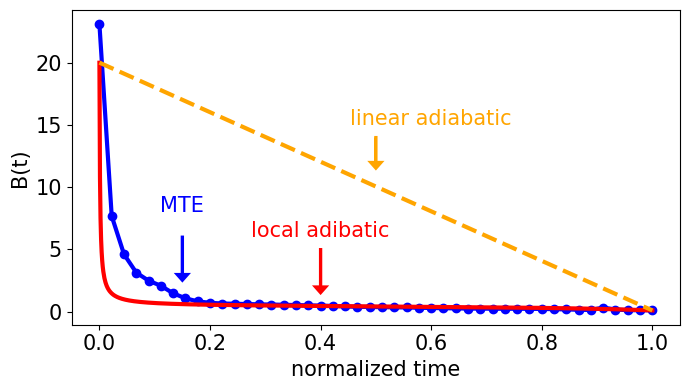

In [25]:
plt.figure(figsize=(7, 4))
for i, x_list in enumerate([x_50]):
    half_length = len(x_list) // 2
    x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
    y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
    plt.plot(x_normalized,y_values, color='blue',linewidth=3)
    plt.plot(x_normalized,y_values,'o',color='blue')

plt.text(x=0.15, y=8, s='MTE', color='blue', fontsize=15, ha='center')
plt.arrow(0.15,6,0.000,-3, head_width=0.02, head_length=0.5, fc='blue', ec='blue', linewidth=2)

plt.text(x=0.4, y=6, s='local adibatic', color='red', fontsize=15, ha='center')
plt.arrow(0.4,5,0.000,-3, head_width=0.02, head_length=0.5, fc='red', ec='red', linewidth=2)

plt.text(x=0.6, y=15, s='linear adiabatic', color='orange', fontsize=15, ha='center')
plt.arrow(0.5,14, 0,-2, head_width=0.02, head_length=0.5, fc='orange', ec='orange', linewidth=2)

plt.plot(t_data_smooth, B_data_smooth, color='red',linewidth=3)
plt.plot(np.linspace(0,1,10000),np.linspace(20,0.1,10000),'--',color='orange',linewidth=3)
# plt.text(0.1, -1, 'LA', color='red', size=20)
plt.tick_params(axis='y', labelcolor='black', labelsize=15)
plt.tick_params(axis='x', labelcolor='black', labelsize=15)
plt.ylabel('B(t)', color='black', size=15)
plt.xlabel('normalized time', size=15)
plt.tight_layout()
plt.savefig('mod_B(t)')
plt.show()

In [26]:
fig_1_mod_filidety= np.array([0.00181, 0.00215, 0.00279, 0.00442, 0.00426, 0.00497, 0.00765,
       0.01561, 0.03101, 0.05398, 0.09484, 0.06081, 0.10408, 0.07147,
       0.08785, 0.1925 , 0.17871, 0.15218, 0.46466, 0.52216, 0.5751 ,
       0.62252, 0.64796, 0.76582, 0.80353, 0.83265, 0.86046, 0.88968,
       0.90704, 0.92185, 0.93517, 0.92945, 0.92071, 0.92387, 0.95268,
       0.95278, 0.97305, 0.98304, 0.98961, 0.9937 , 0.99819, 0.99537,
       0.9991 , 0.99868, 0.9993 , 0.99966])

# This is using the B value from optimzed B field, not accurate enough
# fig_1_mod_inst_gs_fidelity = np.array([0.99834, 0.99867, 0.99603, 0.99482, 0.99738, 0.99678, 0.98501,
#        0.97346, 0.96451, 0.95971, 0.95944, 0.95938, 0.9549 , 0.95109,
#        0.94423, 0.93781, 0.93903, 0.93097, 0.9075 , 0.95042, 0.97811,
#        0.97193, 0.96502, 0.95653, 0.9608 , 0.96768, 0.97708, 0.98278,
#        0.98629, 0.98916, 0.99025, 0.99058, 0.99031, 0.98969, 0.99019,
#        0.99154, 0.9922 , 0.99522, 0.99756, 0.99879, 0.9987 , 0.8283 ,
#        0.99024, 0.99946, 0.99945, 0.99953])

# This is from effective B field 
fig_1_mod_inst_gs_fidelity = np.array([0.9998147531801262,
 0.9987713489348451,
 0.9966360210873704,
 0.9973825539683585,
 0.9976756925420472,
 0.9967844891929778,
 0.9857092012494653,
 0.9754440219279875,
 0.9658816211706688,
 0.9609574752562648,
 0.9595745090167312,
 0.9601485915509431,
 0.9557682294950531,
 0.9542702695367453,
 0.9464484576469021,
 0.9394902251449713,
 0.9395937423106935,
 0.9395639202077454,
 0.9633604897364448,
 0.9782088858051079,
 0.979573219055329,
 0.9730912814592346,
 0.9675193346046856,
 0.9628817953823473,
 0.9714046740003429,
 0.978628507355581,
 0.9831012006008626,
 0.9870860463028203,
 0.9892162821606901,
 0.9902030500136755,
 0.990682838172922,
 0.9905320637421974,
 0.9911943994592438,
 0.9912385800169995,
 0.9923557192805089,
 0.992227982639747,
 0.9956487527039303,
 0.9977136779406992,
 0.9989093079803434,
 0.9988731861343427,
 0.9992993891512661,
 0.9967135357728226,
 0.999502721355659,
 0.9994486873764692,
 0.9995446362013786,
 0.9996614237550087])

# read 
# Load the array from the file
linear_gs = np.load('fig_1_linear_gs_prob.npy')
linear_inst_gs = np.load('fig_1_linear_inst_gs_prob.npy')
final_fidelity_list = np.load('fig_1_la_gs_prob.npy')
instanously_fidelity_list = np.load('fig_1_la_inst_gs_prob.npy')

In [27]:
# # plot all four plots 

# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming x_50 is already defined and contains your data

# # Create a 2x2 subplot
# fig, axs = plt.subplots(2, 2, figsize=(14, 8),sharex=True)

# # Plot the first plot (lambda plot) in the first subplot (0,0)
# plot_x = x_50[:46].detach().cpu().numpy()
# axs[0, 0].plot(np.linspace(0, 1, len(plot_x)), plot_x, color='blue', linewidth=3)
# axs[0, 0].plot(np.linspace(0, 1, len(plot_x)), plot_x, 'o', color='blue')
# axs[0, 0].tick_params(axis='y', labelcolor='black', labelsize=15)
# axs[0, 0].tick_params(axis='x', labelcolor='black', labelsize=15)
# axs[0, 0].set_ylabel(r'$\lambda(t)$ ', color='black', size=15)
# # axs[0, 0].set_xlabel(r'normalized time', size=15)

# # Draw lambda constant line
# axs[0, 0].axhline(y=0.01, color='r', linestyle='-', linewidth=3)
# axs[0, 0].axhline(y=0.01, color='orange', linestyle='--', linewidth=3)

# # Insert text saying which color is which
# axs[0, 0].text(x=0.32, y=8, s='modulated time evolution (MTE)', color='blue', fontsize=15, ha='center')
# axs[0, 0].arrow(0.32, 7, 0, -3, head_width=0.02, head_length=0.5, fc='blue', ec='blue', linewidth=2)

# axs[0, 0].text(x=0.21, y=-4, s='linear adiabatic', color='orange', fontsize=15, ha='center')
# axs[0, 0].arrow(0.21, -3, 0, 2, head_width=0.02, head_length=0.5, fc='orange', ec='orange', linewidth=2)

# axs[0, 0].text(x=0.5, y=-6, s='local adiabatic', color='red', fontsize=15, ha='center')
# axs[0, 0].arrow(0.5, -5, 0, 4, head_width=0.02, head_length=0.5, fc='red', ec='red', linewidth=2)


# # Plot the second plot in the second subplot (0, 1)
# for i, x_list in enumerate([x_50]):
#     half_length = len(x_list) // 2
#     x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
#     y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
#     axs[0, 1].plot(x_normalized, y_values, color='blue', linewidth=3)
#     axs[0, 1].plot(x_normalized, y_values, 'o', color='blue')

# axs[0, 1].text(x=0.15, y=8, s='MTE', color='blue', fontsize=15, ha='center')
# axs[0, 1].arrow(0.15, 6, 0.000, -3, head_width=0.02, head_length=0.5, fc='blue', ec='blue', linewidth=2)

# axs[0, 1].text(x=0.4, y=6, s='local adiabatic', color='red', fontsize=15, ha='center')
# axs[0, 1].arrow(0.4, 5, 0.000, -3, head_width=0.02, head_length=0.5, fc='red', ec='red', linewidth=2)

# axs[0, 1].text(x=0.6, y=15, s='linear adiabatic', color='orange', fontsize=15, ha='center')
# axs[0, 1].arrow(0.5, 14, 0, -2, head_width=0.02, head_length=0.5, fc='orange', ec='orange', linewidth=2)

# axs[0, 1].plot(t_data_smooth, B_data_smooth, color='red', linewidth=3)
# axs[0, 1].plot(np.linspace(0, 1, 10000), np.linspace(20, 0.1, 10000), '--', color='orange', linewidth=3)

# axs[0, 1].tick_params(axis='y', labelcolor='black', labelsize=15)
# axs[0, 1].tick_params(axis='x', labelcolor='black', labelsize=15)
# axs[0, 1].set_ylabel('B(t)', color='black', size=15)
# # axs[0, 1].set_xlabel('normalized time', size=15)
# axs[0, 1].yaxis.tick_right()
# axs[0, 1].yaxis.set_label_position("right")

# # Third subplot (1,0) - Fidelity comparison plot
# axs[1, 0].plot(np.linspace(0, 1, num=len(final_fidelity_list)), final_fidelity_list, color='red', lw=3)
# axs[1, 0].plot(np.linspace(0, 1, num=len(fig_1_mod_filidety)), fig_1_mod_filidety, color='blue', lw=3)
# axs[1, 0].plot(np.linspace(0, 1, num=len(fig_1_mod_filidety)), fig_1_mod_filidety, 'o', color='blue')
# axs[1, 0].plot(np.linspace(0, 1, num=len(linear_gs)), linear_gs, '--', color='orange', lw=3)

# axs[1, 0].set_ylabel(r'$|\langle \psi(t) | \psi_{gs}(t=t_f) \rangle|^2$', color='black', size=15)
# axs[1, 0].set_xlabel('normalized time', size=15)

# axs[1, 0].tick_params(axis='y', labelcolor='black', labelsize=15)
# axs[1, 0].tick_params(axis='x', labelcolor='black', labelsize=15)

# axs[1, 0].text(0.4, 0.9, '46 steps', color='blue', size=15)
# axs[1, 0].text(0.65, 0.1, '2936 steps', color='orange', size=15)
# axs[1, 0].text(0.6, 0.5, '2936 steps', color='red', size=15)


# # Fourth subplot (1,1) - Instantaneous fidelity comparison plot
# axs[1, 1].plot(np.linspace(0, 1, num=len(instanously_fidelity_list)), instanously_fidelity_list, color='red', lw=3)
# axs[1, 1].plot(np.linspace(0, 1, num=len(fig_1_mod_inst_gs_fidelity)), fig_1_mod_inst_gs_fidelity, color='blue', lw=3)
# axs[1, 1].plot(np.linspace(0, 1, num=len(fig_1_mod_inst_gs_fidelity)), fig_1_mod_inst_gs_fidelity, 'o', color='blue')
# axs[1, 1].plot(np.linspace(0, 1, num=len(linear_inst_gs)), linear_inst_gs, '--', color='orange', lw=3)

# axs[1, 1].set_ylabel(r'$|\langle \psi(t) | \psi_{gs}(t) \rangle|^2$', color='black', size=15)
# axs[1, 1].set_xlabel('normalized time', size=15)

# axs[1, 1].tick_params(axis='y', labelcolor='black', labelsize=15)
# axs[1, 1].tick_params(axis='x', labelcolor='black', labelsize=15)
# axs[1, 1].set_ylim(0.90, 1.01)
# axs[1, 1].set_yticks([0.9, 0.95, 1.0])
# axs[1, 1].yaxis.tick_right()
# axs[1, 1].yaxis.set_label_position("right")
# # add label 
# axs[0, 0].text(0.95, 0.95, '(a)', transform=axs[0, 0].transAxes,
#                fontsize=20, va='top', ha='right')
# axs[0, 1].text(0.95, 0.95, '(b)', transform=axs[0, 1].transAxes,
#                fontsize=20, va='top', ha='right')
# axs[1, 0].text(0.95,0.85, '(c)', transform=axs[1, 0].transAxes,
#                fontsize=20, va='top', ha='right')
# axs[1, 1].text(0.99, 0.85, '(d)', transform=axs[1, 1].transAxes,
#                fontsize=20, va='top', ha='right')


# # Tight layout for better spacing
# plt.tight_layout()
# plt.savefig('fig_1.png')
# plt.show()



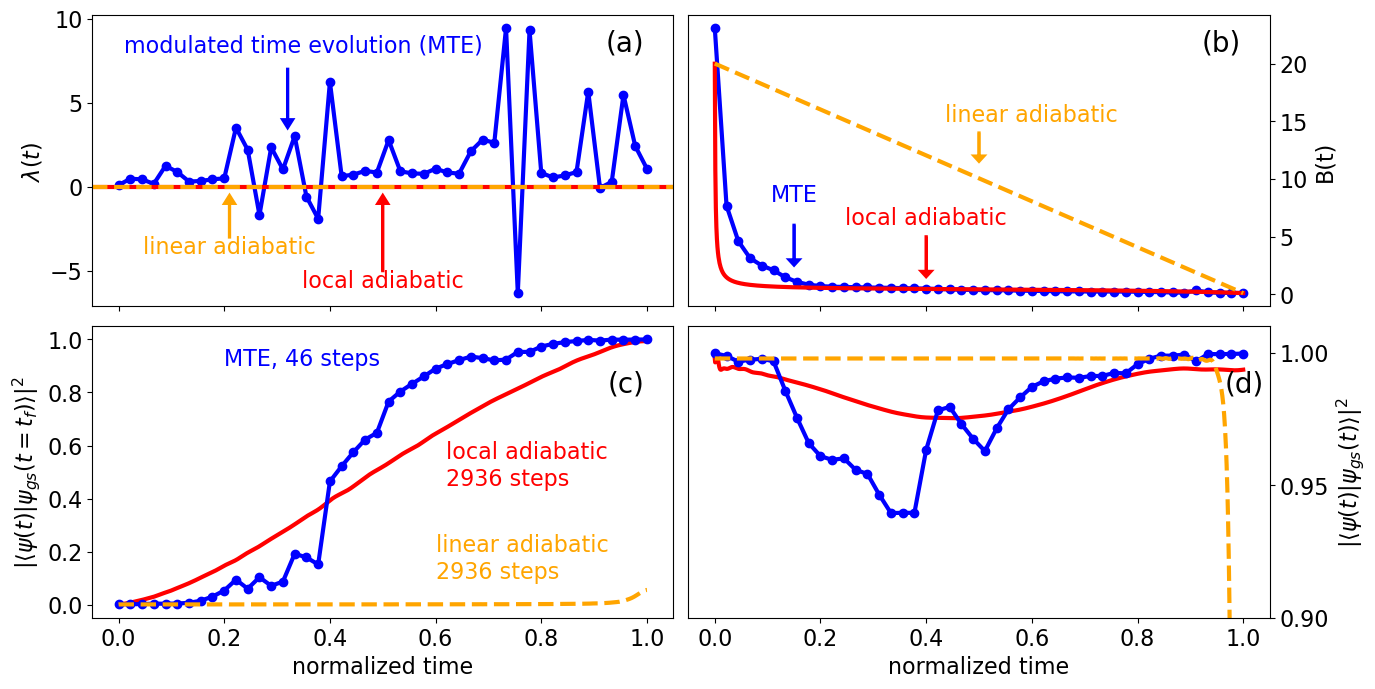

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Define the size parameter
size = 16

# Assuming x_50 is already defined and contains your data

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(14, 7), sharex=True)

# Plot the first plot (lambda plot) in the first subplot (0,0)
plot_x = x_50[:46].detach().cpu().numpy()
axs[0, 0].plot(np.linspace(0, 1, len(plot_x)), plot_x, color='blue', linewidth=3)
axs[0, 0].plot(np.linspace(0, 1, len(plot_x)), plot_x, 'o', color='blue')
axs[0, 0].tick_params(axis='y', labelcolor='black', labelsize=size)
axs[0, 0].tick_params(axis='x', labelcolor='black', labelsize=size)
axs[0, 0].set_ylabel(r'$\lambda(t)$ ', color='black', size=size)

# Draw lambda constant line
axs[0, 0].axhline(y=0.01, color='r', linestyle='-', linewidth=3)
axs[0, 0].axhline(y=0.01, color='orange', linestyle='--', linewidth=3)

# Insert text saying which color is which
axs[0, 0].text(x=0.35, y=8, s='modulated time evolution (MTE)', color='blue', fontsize=16, ha='center')
axs[0, 0].arrow(0.32, 7, 0, -3, head_width=0.02, head_length=0.5, fc='blue', ec='blue', linewidth=2)

axs[0, 0].text(x=0.21, y=-4, s='linear adiabatic', color='orange', fontsize=size, ha='center')
axs[0, 0].arrow(0.21, -3, 0, 2, head_width=0.02, head_length=0.5, fc='orange', ec='orange', linewidth=2)

axs[0, 0].text(x=0.5, y=-6, s='local adiabatic', color='red', fontsize=size, ha='center')
axs[0, 0].arrow(0.5, -5, 0, 4, head_width=0.02, head_length=0.5, fc='red', ec='red', linewidth=2)


# Plot the second plot in the second subplot (0, 1)
for i, x_list in enumerate([x_50]):
    half_length = len(x_list) // 2
    x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
    y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
    axs[0, 1].plot(x_normalized, y_values, color='blue', linewidth=3)
    axs[0, 1].plot(x_normalized, y_values, 'o', color='blue')

axs[0, 1].text(x=0.15, y=8, s='MTE', color='blue', fontsize=size, ha='center')
axs[0, 1].arrow(0.15, 6, 0.000, -3, head_width=0.02, head_length=0.5, fc='blue', ec='blue', linewidth=2)

axs[0, 1].text(x=0.4, y=6, s='local adiabatic', color='red', fontsize=size, ha='center')
axs[0, 1].arrow(0.4, 5, 0.000, -3, head_width=0.02, head_length=0.5, fc='red', ec='red', linewidth=2)

axs[0, 1].text(x=0.6, y=15, s='linear adiabatic', color='orange', fontsize=size, ha='center')
axs[0, 1].arrow(0.5, 14, 0, -2, head_width=0.02, head_length=0.5, fc='orange', ec='orange', linewidth=2)

axs[0, 1].plot(t_data_smooth, B_data_smooth, color='red', linewidth=3)
axs[0, 1].plot(np.linspace(0, 1, 10000), np.linspace(20, 0.1, 10000), '--', color='orange', linewidth=3)

axs[0, 1].tick_params(axis='y', labelcolor='black', labelsize=size)
axs[0, 1].tick_params(axis='x', labelcolor='black', labelsize=size)
axs[0, 1].set_ylabel('B(t)', color='black', size=size)
axs[0, 1].yaxis.tick_right()
axs[0, 1].yaxis.set_label_position("right")

# Third subplot (1,0) - Fidelity comparison plot
axs[1, 0].plot(np.linspace(0, 1, num=len(final_fidelity_list)), final_fidelity_list, color='red', lw=3)
axs[1, 0].plot(np.linspace(0, 1, num=len(fig_1_mod_filidety)), fig_1_mod_filidety, color='blue', lw=3)
axs[1, 0].plot(np.linspace(0, 1, num=len(fig_1_mod_filidety)), fig_1_mod_filidety, 'o', color='blue')
axs[1, 0].plot(np.linspace(0, 1, num=len(linear_gs)), linear_gs, '--', color='orange', lw=3)

axs[1, 0].set_ylabel(r'$|\langle \psi(t) | \psi_{gs}(t=t_f) \rangle|^2$', color='black', size=size)
axs[1, 0].set_xlabel('normalized time', size=size)

axs[1, 0].tick_params(axis='y', labelcolor='black', labelsize=size)
axs[1, 0].tick_params(axis='x', labelcolor='black', labelsize=size)

axs[1, 0].text(0.2, 0.9, 'MTE, 46 steps', color='blue', size=size)
axs[1, 0].text(0.6, 0.1, 'linear adiabatic \n2936 steps', color='orange', size=size)
axs[1, 0].text(0.62, 0.45, 'local adiabatic \n2936 steps', color='red', size=size)


# Fourth subplot (1,1) - Instantaneous fidelity comparison plot
axs[1, 1].plot(np.linspace(0, 1, num=len(instanously_fidelity_list)), instanously_fidelity_list, color='red', lw=3)
axs[1, 1].plot(np.linspace(0, 1, num=len(fig_1_mod_inst_gs_fidelity)), fig_1_mod_inst_gs_fidelity, color='blue', lw=3)
axs[1, 1].plot(np.linspace(0, 1, num=len(fig_1_mod_inst_gs_fidelity)), fig_1_mod_inst_gs_fidelity, 'o', color='blue')
axs[1, 1].plot(np.linspace(0, 1, num=len(linear_inst_gs)), linear_inst_gs, '--', color='orange', lw=3)

axs[1, 1].set_ylabel(r'$|\langle \psi(t) | \psi_{gs}(t) \rangle|^2$', color='black', size=size)
axs[1, 1].set_xlabel('normalized time', size=size)

axs[1, 1].tick_params(axis='y', labelcolor='black', labelsize=size)
axs[1, 1].tick_params(axis='x', labelcolor='black', labelsize=size)
axs[1, 1].set_ylim(0.90, 1.01)
axs[1, 1].set_yticks([0.90, 0.95, 1.0])
axs[1, 1].yaxis.tick_right()
axs[1, 1].yaxis.set_label_position("right")

# Add labels
axs[0, 0].text(0.95, 0.95, '(a)', transform=axs[0, 0].transAxes, fontsize=20, va='top', ha='right')
axs[0, 1].text(0.95, 0.95, '(b)', transform=axs[0, 1].transAxes, fontsize=20, va='top', ha='right')
axs[1, 0].text(0.95, 0.85, '(c)', transform=axs[1, 0].transAxes, fontsize=20, va='top', ha='right')
axs[1, 1].text(0.99, 0.85, '(d)', transform=axs[1, 1].transAxes, fontsize=20, va='top', ha='right')

# Tight layout for better spacing
plt.tight_layout()
plt.savefig('fig_1.png')
plt.show()


In [29]:
# plt.figure(figsize=(7,4))
# for i, x_list in enumerate([x_50]):
#     half_length = len(x_list) // 2
#     x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
#     y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
#     plt.plot(x_normalized, y_values, color='blue',linewidth=3)
#     plt.plot(x_normalized, y_values,'o',color='blue')
#     plt.xlim(0.1,1)
#     plt.ylim(0,2)
# plt.plot(t_data_smooth, B_data_smooth, color='red',linewidth=3)
# plt.plot(np.linspace(0,1,10000),np.linspace(20,0.1,10000), color='orange',linewidth=3)
# # plt.text(0.5, 0.5, 'LA', color='red', size=24)
# plt.tick_params(axis='y', labelcolor='black', labelsize=30)
# plt.tick_params(axis='x', labelcolor='black', labelsize=30)
# plt.ylabel('B(t)', color='black', size=30)
# # plt.xlabel('normalized index of step', size=18)
# plt.tight_layout()
# plt.savefig('inset_mod_B(t)')
# plt.show()

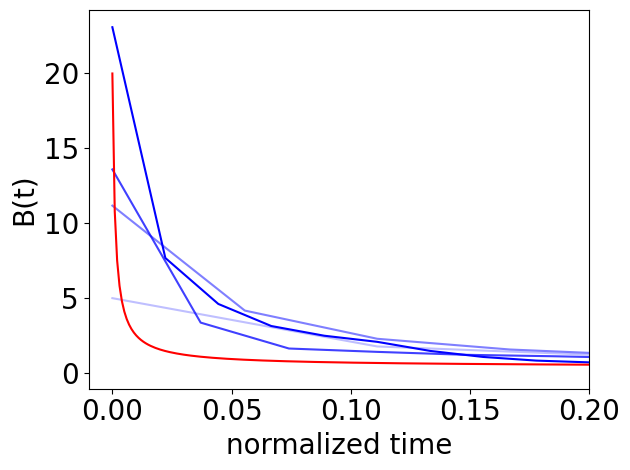

In [30]:
alphas = [0.25 * i for i in range(1, 5)]
# Plot the second half of each array with normalized x-values
for i, x_list in enumerate([x_10, x_20, x_30,x_50]):
    half_length = len(x_list) // 2
    x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
    y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
    plt.plot(x_normalized, y_values, alpha=alphas[i], color='blue')

plt.plot(t_data_smooth, B_data_smooth, color='red')
# plt.text(0.05, 15, 'local adiabatic field', color='red', size=20)
# plt.arrow(0.09, 14, -0.04, -12, head_width=0.01, head_length=0.8, fc='red', ec='red', linewidth=0.01)
plt.tick_params(axis='y', labelcolor='black', labelsize=20)
plt.tick_params(axis='x', labelcolor='black', labelsize=20)
plt.ylabel('B(t)', color='black', size=20)
plt.xlabel('normalized time', size=20)
# plt.text(0., 3, '5 steps', color='blue', size=16)
# plt.text(0.01, 2.8, '40 steps', color='blue', size=16)
plt.xlim(-0.01,0.2)
plt.tight_layout()
plt.savefig('mod_B(t)_till_2')
plt.show()

C:\Users\zachh\AppData\Local\Temp\ipykernel_8216\2064357963.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


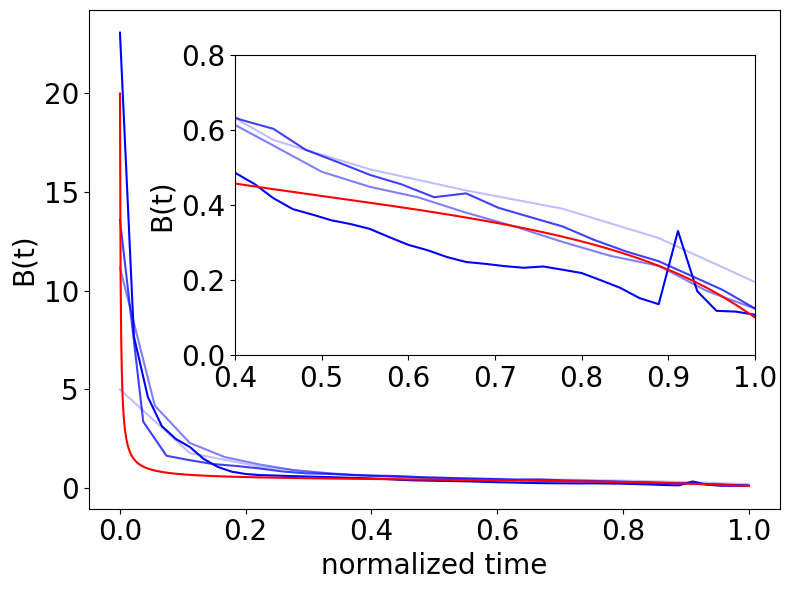

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have defined your data variables t_data_smooth and B_data_smooth
# and arrays x_10, x_20, x_30, x_50

alphas = [0.25 * i for i in range(1, 5)]

# Plot the second half of each array with normalized x-values
fig, ax = plt.subplots(figsize=(8, 6))

for i, x_list in enumerate([x_10, x_20, x_30, x_50]):
    half_length = len(x_list) // 2
    x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
    y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
    ax.plot(x_normalized, y_values, alpha=alphas[i], color='blue')

ax.plot(t_data_smooth, B_data_smooth, color='red')
ax.tick_params(axis='y', labelcolor='black', labelsize=20)
ax.tick_params(axis='x', labelcolor='black', labelsize=20)
ax.set_ylabel('B(t)', color='black', size=20)
ax.set_xlabel('normalized time', size=20)
# ax.set_xlim(-0.01, 0.4)  # Adjusted x-axis limit

# Create inset of width 2 and height 1.5 inches located in the top right corner
ax_inset = fig.add_axes([0.3, 0.4, 0.65, 0.5])
for i, x_list in enumerate([x_10, x_20, x_30, x_50]):
    half_length = len(x_list) // 2
    x_normalized = np.linspace(0, 1, half_length)  # Normalized x-values
    y_values = x_list[half_length:].cpu().detach().numpy()  # Move to CPU and convert to NumPy array
    ax_inset.plot(x_normalized, y_values, alpha=alphas[i], color='blue')

ax_inset.plot(t_data_smooth, B_data_smooth, color='red')
ax_inset.set_xlim(0.4, 1)  # Adjusted x-axis limit for inset
ax_inset.set_ylim(0, 0.8)  # Adjusted y-axis limit for inset

# Set larger font size for inset labels and ticks
ax_inset.tick_params(axis='both', which='major', labelsize=20)
# ax_inset.set_xlabel('normalized time', size=20)
ax_inset.set_ylabel('B(t)', size=20)

plt.tight_layout()
plt.savefig('mod_B(t)_with_inset.png')
plt.show()


In [32]:
import re
import numpy as np

def read_data(file_path):
    costs = []
    params = []
    
    with open(file_path, 'r') as file:
        for line in file:
            # Extract cost
            cost_match = re.search(r'cost = ([\d.-]+)', line)
            if cost_match:
                cost = float(cost_match.group(1))
                costs.append(cost)
            
            # Extract params
            params_match = re.search(r'params = (.+)', line)
            if params_match:
                param_values = list(map(float, params_match.group(1).split(', ')))
                params.append(param_values)
    
    return costs, np.array(params)

# Example usage
file_path = 'jax_bfgs_lambda_B_log_N=12_50.txt'  # Replace with the path to your file
costs, params = read_data(file_path)

costs = np.array(costs)
params = np.array(params)

In [33]:
# fidelity_list= []
# for i in params:
#     fidelity =lambda_evolve(i).item()
#     fidelity_list.append(fidelity)

# fidelity_list = np.array(fidelity_list)

In [34]:
# plt.figure(figsize=(7, 4))
# plt.semilogy(1 - costs / true_gs_energy,color='blue')
# plt.semilogy(1 - fidelity_list,color='orange')
# # Set y-ticks
# plt.yticks([10**-1, 10**-2, 10**-3, 10**-4], 
#            [r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$', r'$10^{-4}$'] )

# plt.xticks([0,500,1000,1500,2000] )

# # Set tick parameters
# plt.tick_params(axis='both', which='major', labelsize=20)

# # Set axis labels and their font size
# plt.xlabel('number of iterations', fontsize=20)

# # Set the main part of the y-axis label, positioned lower
# plt.ylabel(r'$E /E_{gs}$', fontsize=20, color='blue')
# plt.gca().yaxis.set_label_coords(-0.13, 0.3)  # Adjust position of the main label to be lower

# # Add the 'fidelity' part separately in orange, rotated 90 degrees
# plt.text(-0.17, 0.65, 'infidelity', fontsize=20, color='orange', va='center', ha='center', 
#          rotation=90, transform=plt.gca().transAxes)

# plt.tight_layout()
# plt.savefig('fig1_trajectory.png')
# plt.show()


In [35]:
# # Save the NumPy array to a file
# np.save('N=12_50_layers_fidelity_trajector.npy', fidelity_list)